In [33]:
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
m = tf.keras.metrics.Accuracy()
m.update_state([1, 2, 3, 4], [1, 2, 3, 4])
print('Final result: ', m.result().numpy())

Final result:  1.0


In [34]:
from google.colab import files
files.upload()

Saving full_disaster_df.csv to full_disaster_df (1).csv


{'full_disaster_df.csv': b'tweet_texts,Disaster_or_not,Category,source_name,tweet_id,post_time\nStay informed this #hurricaneseason with the Hartford Flood Agent newsletter. Available to all PIA members. Clic... https://t.co/ZNaEwjXCub,0,None,,,\nI thought I was only supposed to flood during hurricanes\xc3\xa2\xe2\x82\xac\xc2\xa6guess I was wrong smfh https://t.co/9wmrQG4M7s,0,None,,,\n#Joplin tornado caught on tape (http://t.co/IyQsDIe),0,None,,,\nDrove through a whole hurricane rain storm with my windshield wipers on OD and now the sun shining blinding me within 15mins... WASSUP VA??,1,Hurricane,,,\n"Flash flood warnings here now. Outfield looks like a pond. Flights have been cancelled. If it were me, I\'d bang it.",1,Flood,,,\n@SJha1618 is this really cloud burst as being claimed? https://t.co/pzslbW1tkh,0,None,,,\nAre there any helping hands from Kathmandu who are moving towards flood victims for rescue?  Please message me if any....,0,None,,,\neverything is shaking there\'s an ear

In [35]:
pip install transformers


In [36]:
import pandas as pd 
import numpy as np 
import re
import string
# import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, Dropout, Bidirectional, TimeDistributed, LSTM, Concatenate
from tensorflow.keras.metrics import AUC
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, TFBertModel, BertConfig
from tokenizers import BertWordPieceTokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score

In [37]:
# disaster_df = pd.read_csv("full_disaster_df.csv", engine = 'python', encoding = 'utf-8')
# disaster_df[disaster_df['Disaster_or_not'].isnull() == True]
# disaster_df = disaster_df.sample(frac = 1)
# disaster_df.fillna("None", inplace = True)
# disaster_df

In [106]:
def data_preprocess(disaster_df):

  def remove_emoji(text):
    emoji = re.compile("["
                        u"\U0001F600-\U0001F64F"  
                        u"\U0001F300-\U0001F5FF"  
                        u"\U0001F680-\U0001F6FF"  
                        u"\U0001F1E0-\U0001F1FF"  
                        u"\U00002702-\U000027B0"
                        u"\U000024C2-\U0001F251"
                        "]+", flags = re.UNICODE)
    return emoji.sub(r'', text)
  
  def remove_punct(text):
    mapping = str.maketrans('', '', string.punctuation)
    return text.translate(mapping)
  
  def remove_links(text):
    text = ''.join([x for x in text if x in string.printable])
    text = re.sub(r'https?://\S+|www\.\S+', "", text)
    return text


  disaster_df['tweet_texts'] = disaster_df['tweet_texts'].apply(lambda x: remove_emoji(x))
  disaster_df['tweet_texts'] = disaster_df['tweet_texts'].apply(lambda x: remove_punct(x))
  disaster_df['tweet_texts'] = disaster_df['tweet_texts'].apply(lambda x: remove_links(x))
  disaster_df['tweet_texts'] = disaster_df['tweet_texts'].apply(lambda x: str(x).lower())
  # return train_df

In [107]:
def bert_encode(text_inputs, tokenizer, max_length = 128):
  tokens = []
  masks = []
  segments = []

  for text in text_inputs:
    text = tokenizer.tokenize(text)
    text = text[:max_length - 2]
    bert_input = ["[CLS]"] + text + ["[SEP]"]
    padding_length = max_length - len(bert_input)
    padding = [0] * padding_length

    token = tokenizer.convert_tokens_to_ids(bert_input)
    token += padding
    mask = [1] * len(bert_input) + padding
    segment = [0] * max_length

    tokens.append(token)
    masks.append(mask)
    segments.append(segment)

  #  return np.array(tokens), np.array(masks), np.array(segments)
  return np.array(tokens), np.array(segments), np.array(masks)

In [108]:
def bert_model(bert_layer, max_length = 128):
  word_ids = Input(shape = (max_length,), dtype = tf.int32)
  masks = Input(shape = (max_length,), dtype = tf.int32)
  segments = Input(shape = (max_length,), dtype = tf.int32)
  # only use the sequence_output,and the valid sequence lenght is only 1( since we need only 1 indicator for classification)
  _, bert_layer_output = bert_layer([word_ids, masks, segments])
  
  
  x = Dense(40, activation = 'relu')(bert_layer_output[:, 0, :])
  x = Dropout(0.2)(x)
  out_label1 = Dense(11, activation = 'softmax',name='type_out')(x)
  out_label2 = Dense(2, activation = 'softmax',name='flag_out')(x)
  
  METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc'),
     ]
  model = Model(inputs = [word_ids, masks, segments], outputs = [out_label1,out_label2])
#   model = tf.keras.Sequential([
#   tf.keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
#   tf.keras.layers.Dropout(0.5),
#   tf.keras.layers.Dense(1, activation='sigmoid')
# ])
  

  model.compile(
  optimizer=tf.keras.optimizers.Adam(lr=1e-3),
  loss=tf.keras.losses.BinaryCrossentropy(),
  metrics=METRICS)

  # model = Model(inputs = [word_ids, masks, segments], outputs = [out_label1,out_label2])
  # model.compile(
  #   optimizer = Adam(lr = 5e-6), 
  #   loss = {
  #     'type_out':'categorical_crossentropy',
  #     'flag_out':'categorical_crossentropy',
  #   },
  #   loss_weights = {
  #     'type_out': 1.,
  #     'flag_out': 0.5 # maybe 0.5, since it s much easier to converge
  #   },
  #  metrics = ['accuracy'])
  return model

In [109]:

# DATA loading
# disaster_df = pd.read_csv("final_none.csv",encoding="unicode_escape")
disaster_df = pd.read_csv("full_disaster_df.csv", engine = 'python', encoding = 'utf-8')
disaster_df[disaster_df['Disaster_or_not'].isnull() == True]
disaster_df = disaster_df.sample(frac = 1)
disaster_df.fillna("None", inplace = True)
# disaster_df = disaster_df[:100]
data_preprocess(disaster_df)


# encode the two labels 
le1 = LabelEncoder()
disaster_df['Category'] = le1.fit_transform(disaster_df['Category'])

le2 = LabelEncoder()
disaster_df['Disaster_or_not'] = le1.fit_transform(disaster_df['Disaster_or_not'])

# pretrained bert model from tensorflow hub
module_url = "https://hub.tensorflow.google.cn/tensorflow/bert_en_uncased_L-12_H-768_A-12/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)
# do toekenization
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

# tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


train_input = bert_encode(disaster_df.tweet_texts.values, tokenizer)

# label 1 
train_label1_value = disaster_df.Category.values
train_label1 = tf.keras.utils.to_categorical(train_label1_value, num_classes=11,dtype = 'int32')

# label 2 
train_label2_value = disaster_df.Disaster_or_not.values
train_label2 =tf.keras.utils.to_categorical(train_label2_value, num_classes=2,dtype = 'int32')

train_labels = [train_label1,train_label2]

# declare the model
model = bert_model(bert_layer)
model.summary()



validation_split = 0.2
epochs = 3 
batch_size = 16

train_history = model.fit(train_input, train_labels, validation_split = validation_split, epochs = epochs, batch_size = batch_size)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
keras_layer_2 (KerasLayer)      [(None, 768), (None, 109482241   input_7[0][0]                    
                                                                 input_8[0][0]              

In [110]:
from matplotlib import pyplot as plt

In [111]:

train_history.history

{'flag_out_accuracy': [0.6407448053359985,
  0.6465582847595215,
  0.6466425061225891],
 'flag_out_auc': [0.6446250081062317, 0.6458608508110046, 0.6464382410049438],
 'flag_out_fn': [4264.0, 4195.0, 4194.0],
 'flag_out_fp': [4264.0, 4195.0, 4194.0],
 'flag_out_loss': [0.6680894494056702, 0.653984010219574, 0.6524866223335266],
 'flag_out_precision': [0.6407448053359985,
  0.6465582847595215,
  0.6466425061225891],
 'flag_out_recall': [0.6407448053359985,
  0.6465582847595215,
  0.6466425061225891],
 'flag_out_tn': [7605.0, 7674.0, 7675.0],
 'flag_out_tp': [7605.0, 7674.0, 7675.0],
 'loss': [0.8925936818122864, 0.8397122621536255, 0.8363175988197327],
 'type_out_accuracy': [0.9319771528244019,
  0.9349568486213684,
  0.9352627396583557],
 'type_out_auc': [0.8713389039039612, 0.8970052003860474, 0.8985551595687866],
 'type_out_fn': [5165.0, 4434.0, 4342.0],
 'type_out_fp': [3716.0, 4058.0, 4110.0],
 'type_out_loss': [0.22450418770313263,
  0.18572862446308136,
  0.1838306486606598],
 't

In [118]:
def plot_metrics(history):
    metrics =  ['flag_out_loss', 'type_out_loss','flag_out_accuracy', 'type_out_accuracy']
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(len(metrics)/2,2,n+1)  
        plt.subplots_adjust(wspace =2, hspace =4)
        plt.plot(history.epoch,  history.history[metric], label='Train')
    
        plt.plot(history.epoch, history.history['val_'+metric],
                  linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        # if metric == 'loss':
        #     plt.ylim([0, plt.ylim()[1]])
        # elif metric == 'auc':
        #     plt.ylim([0.8,1])
        # else:
        #     plt.ylim([0,1])

        # plt.legend()

In [119]:
def plot_metrics_one(history):
    metrics =  ['flag_out_precision', 'type_out_precision','flag_out_recall','type_out_recall']
    for n, metric in enumerate(metrics):
        name = metric
        plt.subplot(len(metrics)/2,2,n+1)  
        plt.subplots_adjust(wspace =2, hspace =4)
        plt.plot(history.epoch,  history.history[metric], label='Train')
        
        plt.plot(history.epoch, history.history['val_'+metric],
                  linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        # plt.legend()

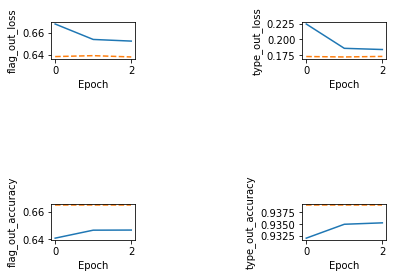

In [120]:
plot_metrics(train_history)

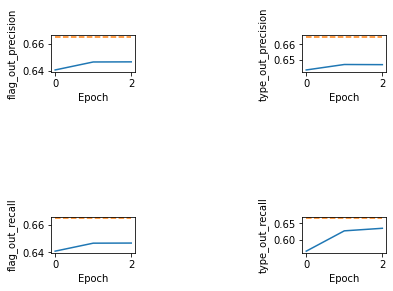

In [121]:
plot_metrics_one(train_history)